# Introduction

This notebook demonstrates an example of displaying an UCoMP and an AIA image in the same map using SunPy.

#### Credits

Thanks to Yingjie Zhu for the initial notebook for this display and pointing out problems in our initial UCoMP level 1 headers.

#### Requirements

- The astropy, sunpy, numpy, matplotlib, and aiapy libraries are required to run this notebook.
- At least one UCoMP and one AIA image that are close in time are also needed. UCoMP images can be obtained from the [UCoMP calendar of the MLSO website](https://mlso.hao.ucar.edu/mlso_data_calendar.php?calinst=ucomp). The images used in the example below are:
  - `20220407.180754.ucomp.1074.l1.p3.fts`
  - `aia.lev1_euv_12s.2022-04-07T120706Z.193.image_lev1.fits`

  Once the MLSO data API is released, we will update this notebook to download the needed files.

In [1]:
import astropy
from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u
import astropy.constants as const
from astropy.visualization import ImageNormalize, SqrtStretch, AsinhStretch

import sunpy
from sunpy.map import Map
from sunpy.map.header_helper import make_fitswcs_header
from sunpy.coordinates.frames import Helioprojective, HeliographicStonyhurst

from aiapy.calibrate import normalize_exposure, register, update_pointing

import numpy as np

import matplotlib.pyplot as plt

# needed to fix up AIA headers for reprojection
import copy

In [2]:
with fits.open("20220407.180754.ucomp.1074.l1.p3.fts") as ucomp_hdul:
    ucomp_hdul.info()
    ucomp_intensity_1074 = ucomp_hdul[2].data[0, :, :]
    ucomp_primary_header = ucomp_hdul[0].header
    ucomp_center_wavelength_header = ucomp_hdul[2].header

Filename: 20220407.180754.ucomp.1074.l1.p3.fts
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     185   ()      
  1  Corona Stokes IQUV [1074.59 nm]    1 ImageHDU        37   (1280, 1024, 4)   float32   
  2  Corona Stokes IQUV [1074.70 nm]    1 ImageHDU        37   (1280, 1024, 4)   float32   
  3  Corona Stokes IQUV [1074.81 nm]    1 ImageHDU        37   (1280, 1024, 4)   float32   
  4  Background I [1074.59 nm]    1 ImageHDU        27   (1280, 1024)   float32   
  5  Background I [1074.70 nm]    1 ImageHDU        27   (1280, 1024)   float32   
  6  Background I [1074.81 nm]    1 ImageHDU        27   (1280, 1024)   float32   


In [3]:
print(repr(ucomp_center_wavelength_header))

# temporarily add RSUN_REF FITS keyword to UCoMP primary header, this will be fixed in the next reprocessing
ucomp_primary_header["RSUN_REF"] = 695700000.

XTENSION= 'IMAGE   '           / extension type                                 
BITPIX  =                  -32 / bits per data value                            
NAXIS   =                    3 / number of axes                                 
NAXIS1  =                 1280 / [pixels] width                                 
NAXIS2  =                 1024 / [pixels] height                                
NAXIS3  =                    4 / polarization states: I, Q, U, V                
PCOUNT  =                    0 /                                                
GCOUNT  =                    1 /                                                
EXTNAME = 'Corona Stokes IQUV [1074.70 nm]' /                                   
INHERIT =                    T / inherit primary header                         
DATATYPE= 'science '           / [sci/cal/dark/flat] science or calibration     
OBJECT  = 'SUN'                / Emission Line Corona                           
WAVELNG =             1074.7

In [4]:
ucomp_map = Map(ucomp_intensity_1074, ucomp_primary_header)

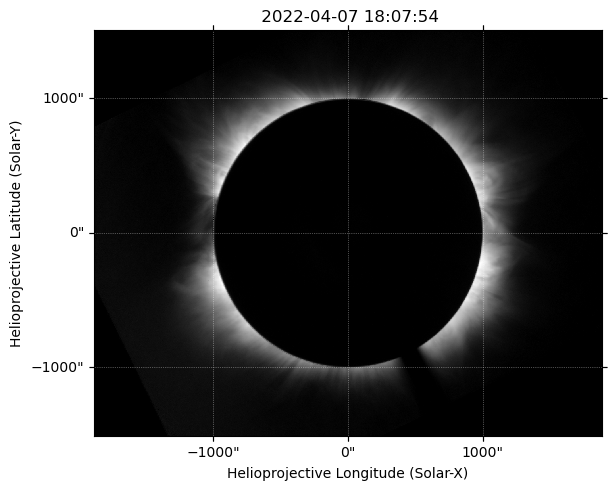

In [5]:
fig = plt.figure(figsize=(6, 6), constrained_layout=True)

norm_ucomp_1074 = ImageNormalize(ucomp_intensity_1074, stretch=AsinhStretch(), vmin=0)
ax = fig.add_subplot(projection=ucomp_map)
_ = ucomp_map.plot(axes=ax, norm=norm_ucomp_1074)

In [6]:
# prepare an AIA image that has already been downloaded for display
aia_filename = "aia.lev1_euv_12s.2022-04-07T120706Z.193.image_lev1.fits"
aia_map = register(update_pointing(Map(aia_filename)))

# Eventually, when we can access MLSO data via an API, we will also access the AIA data via Fido:
#
# result = Fido.search(a.Time("2014-09-19T05:59:00", "2014-09-19T06:01:00"),
#                      a.Instrument("aia"), a.Wavelength(171 * u.angstrom),
#                      a.vso.Sample(12 * u.second))

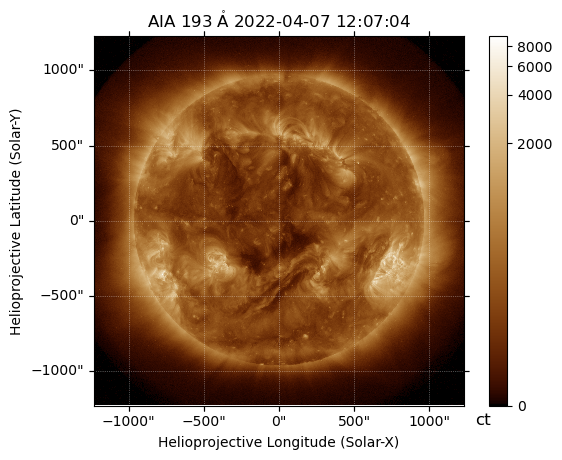

In [7]:
aia_map.peek(vmin=0)

Astropy's FITS reader doesn't seem to want to inherit from the primary header when reading the extension header, even though `INHERIT` is set to 'T'. So we copy the UCoMP primary header and change the `NAXIS` keywords to match the extension data.

In [8]:
ucomp_primary_header_naxis = copy.deepcopy(ucomp_primary_header)
ucomp_primary_header_naxis["NAXIS1"] = ucomp_center_wavelength_header["NAXIS1"]
ucomp_primary_header_naxis["NAXIS2"] = ucomp_center_wavelength_header["NAXIS2"]
del ucomp_primary_header_naxis["NAXIS"]

In [9]:
aia_map_reproject = aia_map.reproject_to(WCS(ucomp_primary_header_naxis))

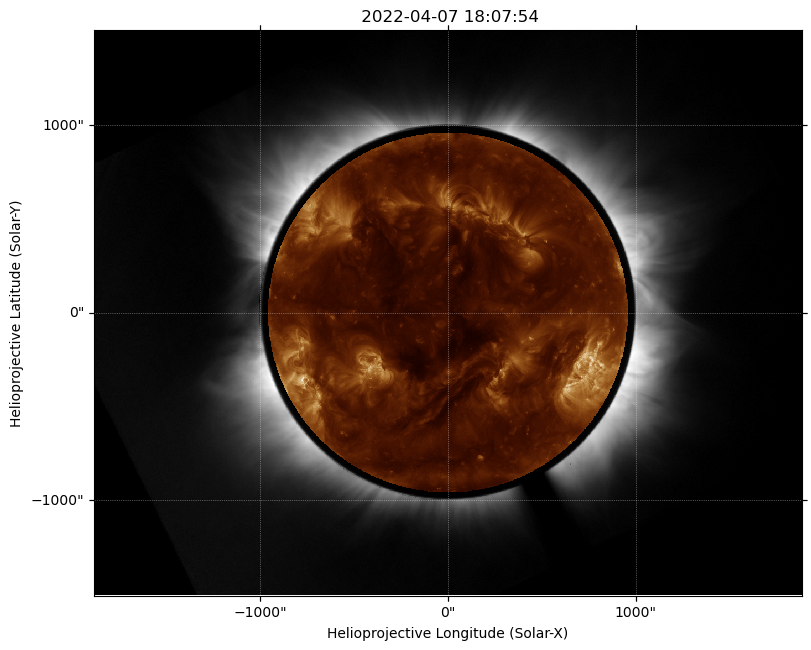

In [10]:
fig = plt.figure(figsize=(8,8), constrained_layout=True)

norm_aia = ImageNormalize(aia_map_reproject.data, stretch=AsinhStretch(), vmin=0)
ax = fig.add_subplot(projection=ucomp_map)

_ = ucomp_map.plot(axes=ax, norm=norm_ucomp_1074)
_ = aia_map_reproject.plot(axes=ax, cmap="sdoaia193", norm=norm_aia, autoalign=True)